# Lab 1 — Deep Learning Backends for Lane Segmentation 
---

## Overview

This lab introduces the **deep learning perception backends** used for lane segmentation in the AutoCar-Kit Lane Keeping system.

You will explore how multiple state-of-the-art segmentation models can be integrated as **interchangeable perception modules**, producing consistent binary lane masks for downstream processing.

The output of this lab serves as the **input foundation** for all subsequent stages, including ROI filtering, BEV transformation, lane geometry estimation, and steering control.

---

## Learning Objectives

After completing this lab, learners will be able to:

1. Explain the role of deep learning–based perception in a lane-keeping pipeline.
2. Compare different lane segmentation backends (YOLOv8, PIDNet, TwinLiteNet, BiSeNet).
3. Load and run pre-trained lane segmentation models for video inference.
4. Convert raw model predictions into binary lane masks.
5. Design perception modules as **black-box components** reusable across multiple pipelines.

This lab establishes the **perception layer** required for robust and modular lane-keeping systems.

# 0. Prepare the environment.


In [1]:
import sys
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


In [14]:
ROOT = Path("../..").resolve()
AI_ROOT = ROOT / "AI"
sys.path.append(str(AI_ROOT))

print("Project ROOT:", ROOT)
print("AI ROOT     :", AI_ROOT)


from configs import config as C

from LaneDetection.backends.yolov8_backend import YoloV8Backend
from LaneDetection.backends.pidnet_backend import PIDNetBackend
from LaneDetection.backends.twinlite_backend import TwinLiteBackend
from LaneDetection.backends.bisenetv2_backend import BiseNetV2Backend

print("LANE_MODEL  (default):", C.LANE_MODEL)
print("LANE_WEIGHTS(default):", C.LANE_WEIGHTS)


Project ROOT: C:\Users\admin\Downloads\ACE_Finalv_visual_FN
AI ROOT     : C:\Users\admin\Downloads\ACE_Finalv_visual_FN\AI
LANE_MODEL  (default): yolov8
LANE_WEIGHTS(default): C:\Users\admin\Downloads\ACE_Finalv_visual_FN\AI\LaneDetection\Lane_weight\Yolo_v8\best.pt


In [15]:
import torch

print("Before override, C.DEVICE =", C.DEVICE)
print("torch.cuda.is_available():", torch.cuda.is_available())
C.DEVICE = "cpu"

print("After override,  C.DEVICE =", C.DEVICE)


Before override, C.DEVICE = cpu
torch.cuda.is_available(): False
After override,  C.DEVICE = cpu


## 1. Build a deep learning backend


In [16]:
# Map from model name -> filename weight in Lane_weight folder
LANE_WEIGHT_NAME = {
    "yolov8":  "Yolo_v8/best.pt",
    "pidnet":  "PIDNet/best.pt",
    "twinlite":"TwinLite/best.pth",
    "bisenet": "BiseNet/best.pth",
}

def get_lane_weight_path(model_name: str) -> Path:
    """
    Returns the full path to the weight file for model_name.
    """
    name = model_name.lower()
    if name not in LANE_WEIGHT_NAME:
        raise ValueError(f"Unknown lane model: {model_name}")

    weights_dir = C.ROOT / "AI" / "LaneDetection" / "Lane_weight"
    weight_rel  = LANE_WEIGHT_NAME[name]
    weight_path = weights_dir / weight_rel
    return weight_path


In [10]:
def build_backend(model_name: str):
    """
    Initialize the corresponding backend lane segmentation.

    Parameters
    ----------
    model_name : str
        'yolov8' | 'pidnet' | 'twinlite' | 'bisenet'
    """
    name = model_name.lower()
    weights = get_lane_weight_path(name)

    if name == "yolov8":
        backend = YoloV8Backend(
            weights=str(weights),
            device=C.DEVICE,
            imgsz=C.IMGSZ,
            conf=C.CONF,
        )
    elif name == "pidnet":
        backend = PIDNetBackend(
            weights=str(weights),
            device=C.DEVICE,
            input_h=C.PIDNET_H,
            input_w=C.PIDNET_W,
            thr=C.PIDNET_THR,
            arch=C.PIDNET_ARCH,
        )
    elif name == "twinlite":
        backend = TwinLiteBackend(
            weights=str(weights),
            device=C.DEVICE,
            input_h=C.TWIN_H,
            input_w=C.TWIN_W,
            thr=C.TWIN_THR,
            num_classes=C.TWIN_NUM_CLASSES,
        )
    elif name == "bisenet":
        backend = BiseNetV2Backend(
            weights=str(weights),
            device=C.DEVICE,
            input_h=C.BISENET_H,
            input_w=C.BISENET_W,
            num_classes=C.BISENET_NUM_CLASSES,
        )
    else:
        raise ValueError(f"Unknown model_name: {model_name}")

    return backend


In [17]:
# Quick build_backend check
for name in ["yolov8", "pidnet", "twinlite", "bisenet"]:
    try:
        b = build_backend(name)
        print(f"{name:8s} ->", b.__class__.__name__)
    except Exception as e:
        print(f"{name:8s} -> ERROR:", e)


YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 11.3 GFLOPs
yolov8   -> YoloV8Backend
[PIDNet] loaded=479  missing=0  unexpected=26
pidnet   -> PIDNetBackend
[TwinLite] loaded=157  missing=0  unexpected=0
twinlite -> TwinLiteBackend
[BiSeNetV2] Loaded weights from: C:\Users\admin\Downloads\ACE_Finalv_visual_FN\AI\LaneDetection\Lane_weight\BiseNet\best.pth
[BiSeNetV2] Device: cpu, input: 256x256
bisenet  -> BiseNetV2Backend


## 2. Load the sample frames


In [21]:
FRAMES_DIR = ROOT / "Lab" / "Lab1" / "Lab1_frames"

print("Frames dir:", FRAMES_DIR)

frame_paths = sorted(FRAMES_DIR.glob("Lab1_frames_*.png"))
print("Number of frames found:", len(frame_paths))
for p in frame_paths[:5]:
    print(" -", p)


Frames dir: C:\Users\admin\Downloads\ACE_Finalv_visual_FN\Lab\Lab1\Lab1_frames
Number of frames found: 10
 - C:\Users\admin\Downloads\ACE_Finalv_visual_FN\Lab\Lab1\Lab1_frames\Lab1_frames_1.png
 - C:\Users\admin\Downloads\ACE_Finalv_visual_FN\Lab\Lab1\Lab1_frames\Lab1_frames_10.png
 - C:\Users\admin\Downloads\ACE_Finalv_visual_FN\Lab\Lab1\Lab1_frames\Lab1_frames_2.png
 - C:\Users\admin\Downloads\ACE_Finalv_visual_FN\Lab\Lab1\Lab1_frames\Lab1_frames_3.png
 - C:\Users\admin\Downloads\ACE_Finalv_visual_FN\Lab\Lab1\Lab1_frames\Lab1_frames_4.png


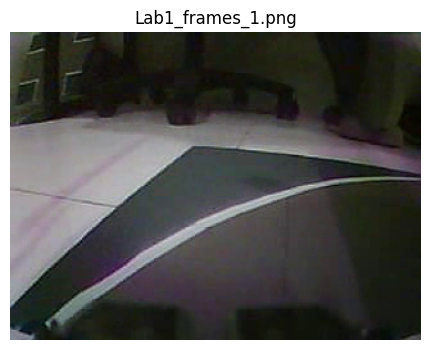

In [22]:
# Show a test frame
if len(frame_paths) == 0:
    raise RuntimeError("No frames found in data/lab1_frames")

sample_path = frame_paths[0]
frame_bgr = cv2.imread(str(sample_path))
if frame_bgr is None:
    raise FileNotFoundError(f"Unable to read the image.: {sample_path}")

frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,4))
plt.imshow(frame_rgb)
plt.title(sample_path.name)
plt.axis("off")
plt.show()


## 3. Build a function to visualize frames together with lane masks


In [23]:
def show_frame_and_mask(frame_bgr, mask01, title=""):
    """Display the original frame and the frame with the overlay lane.."""
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

    overlay = frame_rgb.copy()
    overlay[mask01 > 0] = [255, 0, 0]

    alpha = 0.5
    blended = cv2.addWeighted(frame_rgb, 1 - alpha, overlay, alpha, 0)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(frame_rgb)
    plt.title("Original frame")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(blended)
    plt.title(title)
    plt.axis("off")

    plt.tight_layout()
    plt.show()


## 4. Test running a backend (TwinliteNet)


[TwinLite] loaded=157  missing=0  unexpected=0
Frame shape: (240, 320, 3)
Mask  shape: (240, 320)
Mask01 unique: [0 1]


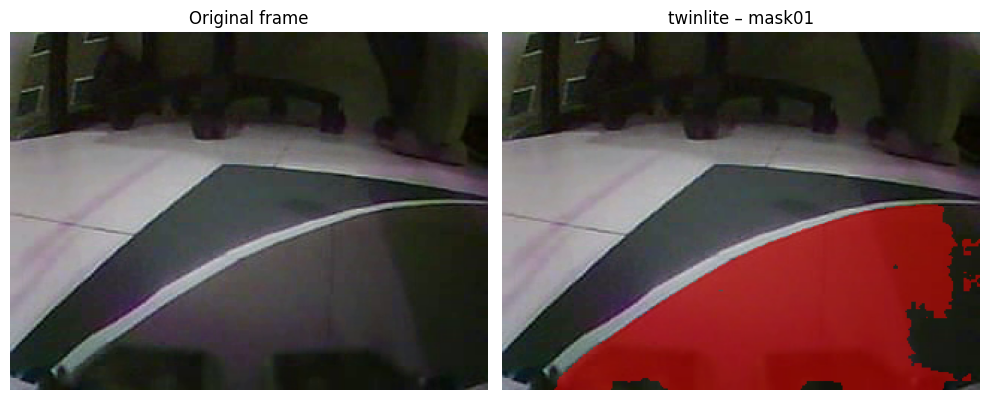

In [ ]:
backend = build_backend("twinlite") # Change the model name if you want to use a different bankend (Yolov8, BiseNet, PidNet)
sample_path = frame_paths[0]
frame_bgr = cv2.imread(str(sample_path))

mask = backend.infer_mask01(frame_bgr)
mask01 = (mask > 0).astype(np.uint8)

print("Frame shape:", frame_bgr.shape)
print("Mask  shape:", mask.shape)
print("Mask01 unique:", np.unique(mask01))

show_frame_and_mask(frame_bgr, mask01, title="twinlite – mask01")  


## 5. Compare 4 backends on the same frame (Answer)


YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 11.3 GFLOPs
[PIDNet] loaded=479  missing=0  unexpected=26
[TwinLite] loaded=157  missing=0  unexpected=0
[BiSeNetV2] Loaded weights from: C:\Users\admin\Downloads\ACE_Finalv_visual_FN\AI\LaneDetection\Lane_weight\BiseNet\best.pth
[BiSeNetV2] Device: cpu, input: 256x256


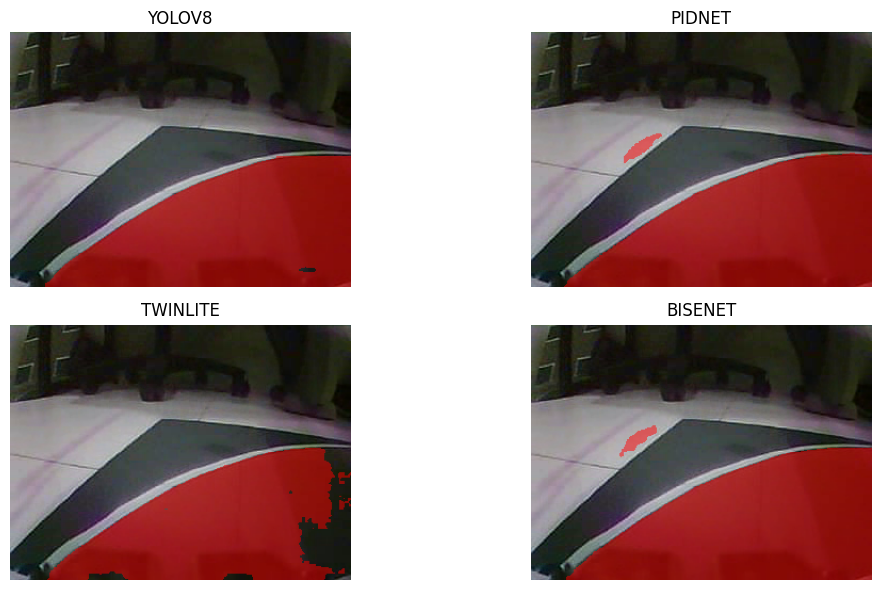

In [18]:
model_names = ["yolov8", "pidnet", "twinlite", "bisenet"]

sample_path = frame_paths[0]
frame_bgr = cv2.imread(str(sample_path))

plt.figure(figsize=(12, 6))

for i, name in enumerate(model_names, start=1):
    backend = build_backend(name)
    mask = backend.infer_mask01(frame_bgr)
    mask01 = (mask > 0).astype(np.uint8)

    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    overlay = frame_rgb.copy()
    overlay[mask01 > 0] = [255, 0, 0]
    blended = cv2.addWeighted(frame_rgb, 0.5, overlay, 0.5, 0)

    plt.subplot(2, 2, i)
    plt.imshow(blended)
    plt.title(name.upper())
    plt.axis("off")

plt.tight_layout()
plt.show()


## 6. Create and store binary lane masks for analysis purposes


In [26]:
import os

MODEL_FOR_LAB2 = "twinlite" #🔁 Choose backend (Yolov8, BiseNet, PidNet)

backend = build_backend(MODEL_FOR_LAB2)

OUT_DIR = ROOT / "Lab" / "Lab1" / "Lab1_masks"
OUT_DIR.mkdir(parents=True, exist_ok=True)

for i, p in enumerate(frame_paths, start=1):
    frame_bgr = cv2.imread(str(p))
    if frame_bgr is None:
        raise FileNotFoundError(f"Unable to read the image: {p}")
    
    mask = backend.infer_mask01(frame_bgr)
    mask01 = (mask > 0).astype(np.uint8)     # 0/1

    mask_png = mask01 * 255                  # 0/1 → 0/255

    out_path = OUT_DIR / f"Lab1_mask01_{i:02d}.png"
    cv2.imwrite(str(out_path), mask_png)

    print("Saved:", out_path)



[TwinLite] loaded=157  missing=0  unexpected=0
Saved: C:\Users\admin\Downloads\ACE_Finalv_visual_FN\Lab\Lab1\Lab1_masks\Lab1_mask01_01.png
Saved: C:\Users\admin\Downloads\ACE_Finalv_visual_FN\Lab\Lab1\Lab1_masks\Lab1_mask01_02.png
Saved: C:\Users\admin\Downloads\ACE_Finalv_visual_FN\Lab\Lab1\Lab1_masks\Lab1_mask01_03.png
Saved: C:\Users\admin\Downloads\ACE_Finalv_visual_FN\Lab\Lab1\Lab1_masks\Lab1_mask01_04.png
Saved: C:\Users\admin\Downloads\ACE_Finalv_visual_FN\Lab\Lab1\Lab1_masks\Lab1_mask01_05.png
Saved: C:\Users\admin\Downloads\ACE_Finalv_visual_FN\Lab\Lab1\Lab1_masks\Lab1_mask01_06.png
Saved: C:\Users\admin\Downloads\ACE_Finalv_visual_FN\Lab\Lab1\Lab1_masks\Lab1_mask01_07.png
Saved: C:\Users\admin\Downloads\ACE_Finalv_visual_FN\Lab\Lab1\Lab1_masks\Lab1_mask01_08.png
Saved: C:\Users\admin\Downloads\ACE_Finalv_visual_FN\Lab\Lab1\Lab1_masks\Lab1_mask01_09.png
Saved: C:\Users\admin\Downloads\ACE_Finalv_visual_FN\Lab\Lab1\Lab1_masks\Lab1_mask01_10.png


# Done